# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [505]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, accuracy_score

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [506]:
df.shape

(750000, 15)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [507]:
df['data_ref'].unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]

In [508]:
oot = df[df['data_ref'].dt.year == 2016]
oot.drop(columns=['data_ref', 'index'], inplace=True)

<ipython-input-508-58c32419d673>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot.drop(columns=['data_ref', 'index'], inplace=True)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [509]:
df['data_ref'].groupby(df['data_ref'].dt.to_period("M")).count()

data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: data_ref, dtype: int64

In [510]:
df.drop(columns=['data_ref', 'index'], inplace=True)
qualitativas = df.select_dtypes(include=['object', 'bool'])
quantitativas = df.select_dtypes(include=['int64', 'float64'])

In [511]:
qualitativas.describe()

,sexo,posse_de_veiculo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia,mau
count,750000,750000,750000,750000,750000,750000,750000,750000
unique,2,2,2,5,5,5,6,2
top,F,N,S,Assalariado,Médio,Casado,Casa,False
freq,504580,457954,503692,385740,506836,526472,674294,691357


In [512]:
quantitativas.describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,0.433251,43.804733,7.748574,2.212241,2.323854e+04
std,0.739379,11.229868,6.687455,0.903428,7.910601e+04
min,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [513]:
for i, c1 in enumerate(qualitativas.columns):
  for c2 in qualitativas.columns[i+1:]:
    biv = pd.crosstab(df[c1], df[c2])
    chi2, p, dof, ex = chi2_contingency(biv)

    print(f"\nTabela cruzada entre {c1} e {c2}:")
    print(f"Chi-square test: chi2={chi2}, p-value={p}")


Tabela cruzada entre sexo e posse_de_veiculo:
Chi-square test: chi2=100870.0291516938, p-value=0.0

Tabela cruzada entre sexo e posse_de_imovel:
Chi-square test: chi2=2247.527514858336, p-value=0.0

Tabela cruzada entre sexo e tipo_renda:
Chi-square test: chi2=27113.00580105838, p-value=0.0

Tabela cruzada entre sexo e educacao:
Chi-square test: chi2=384.9910277454786, p-value=4.863304187399432e-82

Tabela cruzada entre sexo e estado_civil:
Chi-square test: chi2=21786.607684070288, p-value=0.0

Tabela cruzada entre sexo e tipo_residencia:
Chi-square test: chi2=6928.579347657816, p-value=0.0

Tabela cruzada entre sexo e mau:
Chi-square test: chi2=116.21959444110506, p-value=4.2547733301804896e-27

Tabela cruzada entre posse_de_veiculo e posse_de_imovel:
Chi-square test: chi2=483.2102844969865, p-value=4.277575986479031e-107

Tabela cruzada entre posse_de_veiculo e tipo_renda:
Chi-square test: chi2=17561.783634048443, p-value=0.0

Tabela cruzada entre posse_de_veiculo e educacao:
Chi-sq

In [514]:
corr = quantitativas.corr()

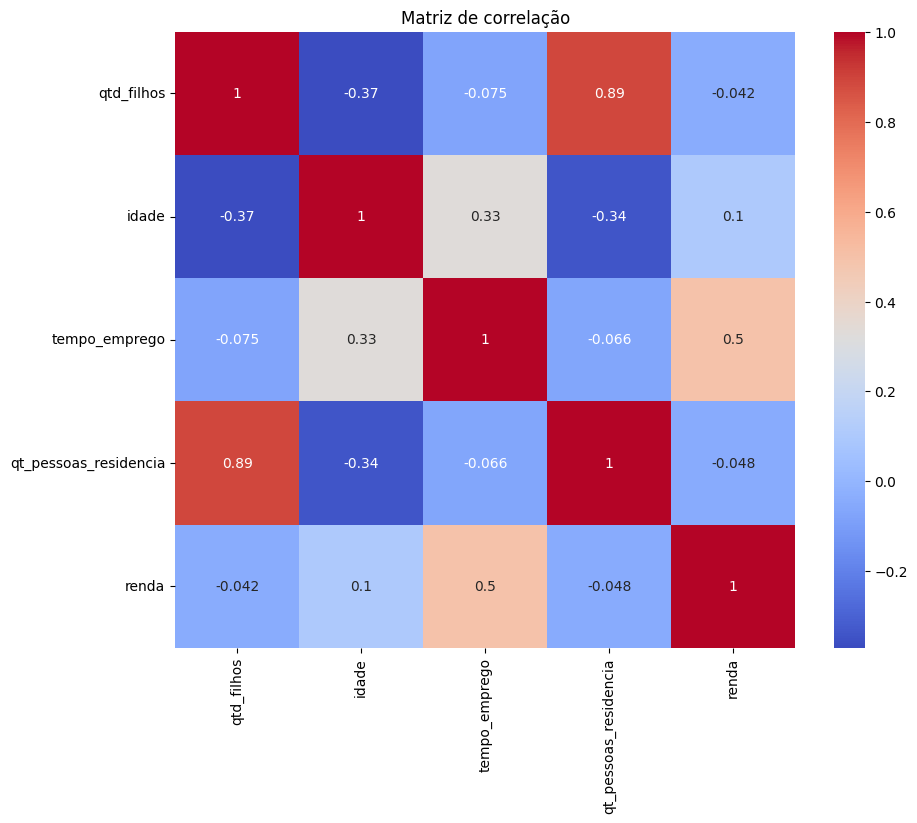

In [515]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlação")
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [516]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [517]:
df.isna().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [518]:
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

In [519]:
for column in quantitativas:
  df = remove_outliers(df, column)

In [520]:
qualitativas.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia', 'mau'],
      dtype='object')

In [521]:
df['estado_civil'].value_counts()

estado_civil
Casado      436971
Solteiro     77529
União        48739
Separado     34696
Viúvo        27198
Name: count, dtype: int64

In [522]:
df['tipo_renda'].value_counts()

tipo_renda
Assalariado         314031
Empresário          144933
Pensionista         120180
Servidor público     45691
Bolsista               298
Name: count, dtype: int64

In [523]:
df['educacao'] = df['educacao'].replace(['Superior completo', 'Superior incompleto', 'Pós graduação'], 'Alta Escolaridade')
df['educacao'] = df['educacao'].replace(['Médio', 'Fundamental'], 'Baixa Escolaridade')

df['tipo_renda'] = df['tipo_renda'].replace(['Assalariado', 'Servidor público'], 'Assalariado')

df['estado_civil'] = df['estado_civil'].replace(['Viúvo', 'Separado', 'Solteiro'], 'Solteiro')
df['estado_civil'] = df['estado_civil'].replace(['Casado', 'União'], 'Compromissado')

In [524]:
df['mau'] = df['mau'].astype(int)

In [525]:
df['mau'].value_counts()

mau
0    568414
1     56719
Name: count, dtype: int64

## Desenvolver o modelo

In [526]:
df = pd.get_dummies(df)

In [527]:
X = df.drop(columns=['mau'])
y = df['mau']

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [529]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [530]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [531]:
coefficients = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': model.coef_[0]})
coefficients.sort_values(by='Coefficient', ascending=False)

,Variable,Coefficient
14,tipo_renda_Pensionista,0.071480
0,qtd_filhos,0.051904
23,tipo_residencia_Estúdio,0.000357
24,tipo_residencia_Governamental,0.000300
12,tipo_renda_Bolsista,0.000048
4,renda,-0.000178
17,estado_civil_Compromissado,-0.002358
22,tipo_residencia_Comunitário,-0.002744
19,tipo_residencia_Aluguel,-0.006099
1,idade,-0.007824


Categorias que têm coeficientes muito próximos de zero ou que não contribuem significativamente para o modelo podem ser removidas.

Equação preditiva:

$$
\text{logit}(p) = \beta_0 + \sum_{i=1}^{n} \beta_i X_i
$$

Onde:

logit(p) é o logaritmo da razão de chances de
𝑝
p (a probabilidade de inadimplência).
𝛽
0
β
0
​
  é o intercepto.
𝛽
𝑖
β
i
​
  são os coeficientes das variáveis explicativas
𝑋
𝑖
X
i
​
 .

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [532]:
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))

In [533]:
print("Acurácia nos dados de treino:", train_accuracy)
print("Acurácia nos dados de teste:", test_accuracy)

Acurácia nos dados de treino: 0.9091164621006278
Acurácia nos dados de teste: 0.9096246134158046


In [534]:
y_test[y_test==1]

673862    1
658359    1
272585    1
637990    1
749176    1
         ..
563931    1
180629    1
718232    1
623972    1
50991     1
Name: mau, Length: 16949, dtype: int64

In [535]:
k2_test, _ = ks_2samp(y_test==1, y_test==0)
k2_train, _ = ks_2samp(y_train==1, y_train==1)

In [536]:
print("K2 nos dados de treino:", k2_test)
print("K2 nos dados de teste:", k2_train)

K2 nos dados de treino: 0.8192492268316092
K2 nos dados de teste: 0.0


In [537]:
def gini_score(y_true, y_pred_prob):
    auc = roc_auc_score(y_true, y_pred_prob)
    return 2 * auc - 1

In [538]:
train_gini = gini_score(y_train, model.predict_proba(X_train)[:, 1])
test_gini = gini_score(y_test, y_pred_prob)

In [539]:
print("Gini nos dados de treino:", train_gini)
print("Gini nos dados de teste:", test_gini)

Gini nos dados de treino: 0.4942977074781296
Gini nos dados de teste: 0.5025729557409702


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

In [544]:
df = pd.read_feather("/content/credit_scoring.ftr").drop(columns=['data_ref', 'index'])
df['mau'] = df['mau'].astype(int)

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [545]:
df.isna().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [546]:
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [547]:
qualitativas = df.select_dtypes(include=['object', 'bool']).columns
quantitativas = df.select_dtypes(include=['int64', 'float64']).columns.drop('mau')

In [548]:
for column in quantitativas:
  df = remove_outliers(df, column)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

<Axes: ylabel='Feature'>

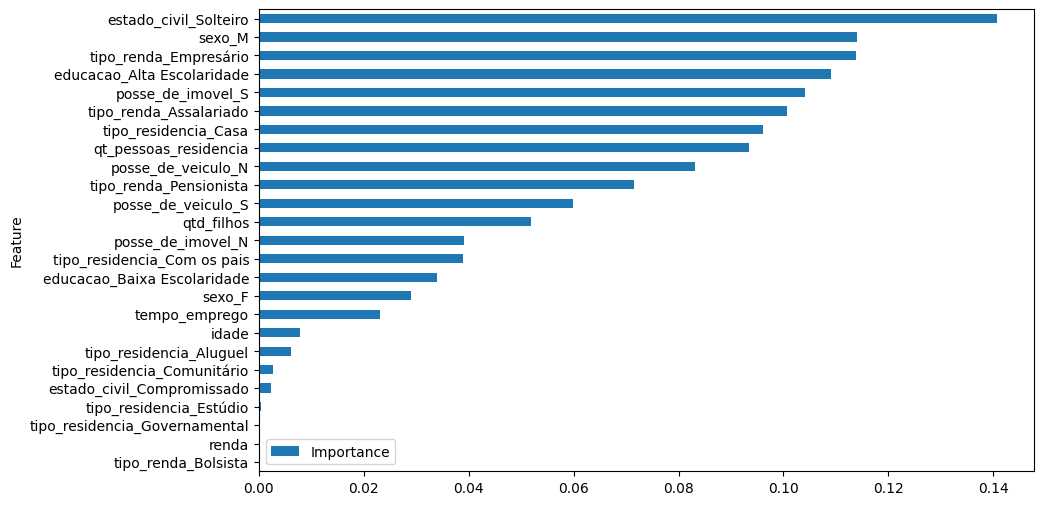

In [549]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [550]:
features = []
for i, row in feature_importance.iterrows():
  if row['Importance'] > 0.03:
    features.append(row['Feature'])

In [551]:
features

['educacao_Baixa Escolaridade',
 'tipo_residencia_Com os pais',
 'posse_de_imovel_N',
 'qtd_filhos',
 'posse_de_veiculo_S',
 'tipo_renda_Pensionista',
 'posse_de_veiculo_N',
 'qt_pessoas_residencia',
 'tipo_residencia_Casa',
 'tipo_renda_Assalariado',
 'posse_de_imovel_S',
 'educacao_Alta Escolaridade',
 'tipo_renda_Empresário',
 'sexo_M',
 'estado_civil_Solteiro']

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [552]:
df = pd.get_dummies(df).astype(int)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [553]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

In [554]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(scaled)

In [555]:
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(5)])

In [556]:
pca_df

,PC1,PC2,PC3,PC4,PC5
0,-1.951603,2.633525,-0.294925,0.693175,-0.500511
1,0.453553,-1.139948,-0.561957,-0.461074,-0.872712
2,1.472849,0.520815,2.659661,-2.681422,-1.191990
3,-1.012903,0.583682,0.513188,-2.017396,0.946003
4,0.432468,2.703733,-0.840709,1.918975,-0.973076
...,...,...,...,...,...
625128,0.494026,-0.722287,0.215885,2.069160,0.402855
625129,-3.971733,0.187073,-1.238352,0.589514,-0.557145
625130,3.579917,-0.523742,-0.295078,-2.430192,0.027312
625131,-3.301096,-0.073041,-0.666675,-0.632704,-1.117147


### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [557]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('mau')

In [558]:
# Remoção de nulos e outliers para variáveis numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression())
])

In [559]:
X = df.drop(columns='mau')
y = df['mau']

In [564]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [565]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'sexo_F', 'sexo_M', 'posse_de_veiculo_N', 'posse_de_veiculo_S',
       'posse_de_imovel_N', 'posse_de_imovel_S', 'tipo_renda_As...
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel',
       'tipo_residencia_Casa', 'tipo_residencia_Com os pais',
       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio',
       'tipo_residencia_Governamental'],
      dtype='object'))])),
                ('pca', PCA(n_components=5)),
                ('classifier', LogisticRegression())])

In [568]:
y_pred = pipeline.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [570]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.

In [3]:
import pandas as pd
from pycaret.classification import *

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [9]:
exp = setup(df, target='mau')

,Description,Value
0,Session id,5713
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [10]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [11]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9222,0.7731,0.0268,0.5528,0.0511,0.0442,0.1090
1,0.9221,0.7811,0.0261,0.5350,0.0497,0.0428,0.1052
2,0.9221,0.7818,0.0273,0.5411,0.0519,0.0448,0.1085
3,0.9224,0.7845,0.0275,0.5795,0.0526,0.0458,0.1140
4,0.9230,0.7913,0.0312,0.6531,0.0595,0.0528,0.1311
5,0.9219,0.7885,0.0256,0.5172,0.0487,0.0417,0.1019
6,0.9221,0.7739,0.0248,0.5340,0.0475,0.0408,0.1026
7,0.9220,0.7805,0.0292,0.5263,0.0554,0.0476,0.1102
8,0.9224,0.7759,0.0275,0.5825,0.0526,0.0458,0.1144


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

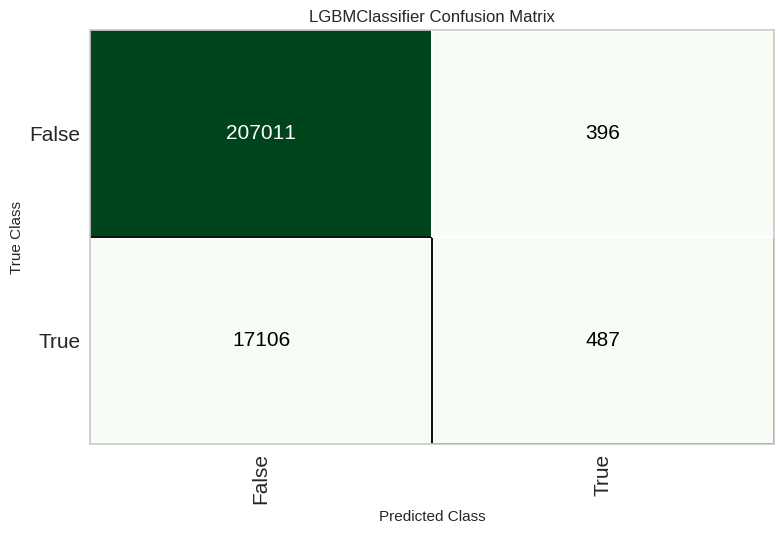

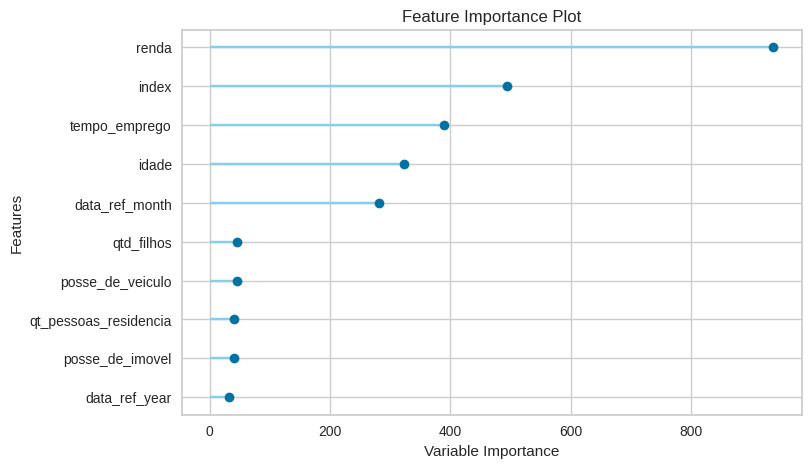

In [13]:
plot_model(lgbm, plot='confusion_matrix')
plot_model(lgbm, plot='feature')